In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from torch.distributions import MultivariateNormal

In [2]:
plt.rc('font', size=14)          # controls default text sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)

        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layerout = nn.Linear(self.hidden_dim, x_dim-1, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=1)

        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 

        h_temp = self.activation(self.layer_3(h))
        h_temp = self.activation(self.layer_4(h_temp))
        h = h_temp + h
        
        z_out = self.layerout(h) 
        return z_out

In [4]:
N = 2000 # number of samples
T = 100  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 1.0 # time horizon
# dt = tf/T # time step

n_sigma = 0.3 # noise level

A = torch.tensor([[0.0, 1.0],[0.0, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [5]:
x_0 = torch.tensor([[0.0],[0.0]])
y = torch.tensor([[2.0],[0.0]])

In [6]:
t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid shape (T,1)

In [7]:
def generate_phit(t, n):
    """
    t shape is (T, 1), output shape is (T, n, n)
    """
    T, _ = t.shape
    phi_t = torch.zeros((T, n, n))
    phi_t[:,0,0] = t[:,0]**3/3
    phi_t[:,0,1] = t[:,0]**2/2
    phi_t[:,1,0] = t[:,0]**2/2
    phi_t[:,1,1] = t[:,0]
    return phi_t

In [8]:
def generate_expAt(A, t):
    """
    A shape is (n,n), t shape is (T,1), output shape is (T,n,n)
    """
    T, _ = t.shape
    A_rep = A.repeat(T,1,1)
    A_t = A_rep * t.unsqueeze(-1)
    A_t_exp = torch.matrix_exp(A_t)

    return A_t_exp

In [9]:
exp1tAtrans = generate_expAt(A.T, 1-t)
expA = generate_expAt(A, torch.ones_like(t))[0,:,:]
phi_1 = generate_phit(torch.ones_like(t), n)

U_d = torch.einsum('tij,tjk->tik', torch.einsum('ij,tjk->tik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1)) @ (y - expA @ x_0).squeeze(-1)

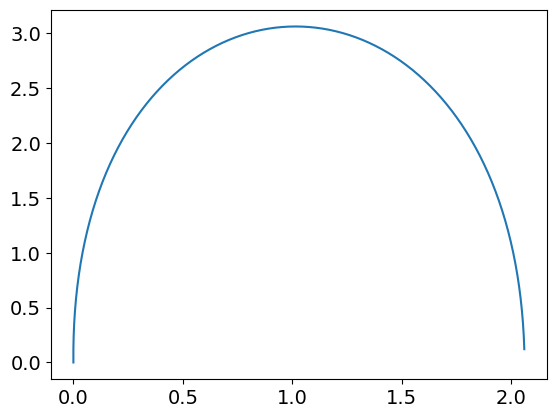

In [10]:
dt = t[1] - t[0]
X_forward = torch.zeros((T, n))
X_forward[0,:] = x_0.squeeze(-1)
for i in range(1, T):
    # print(i)
    X_forward[i,:] = (A @ X_forward[i-1,:] + B @ U_d[i-1,:]) * dt + X_forward[i-1,:]

plt.figure()
plt.plot(X_forward[:,0], X_forward[:,1])
plt.show()

In [11]:
### Generate backward data
X_backward = torch.zeros((T, N, n))
X_backward[-1,:,:] = y.repeat(N,1).reshape(N,n)
for i in range(T-1, 0, -1):
    # print(i)
    dX = (A @ X_backward[i,:,:].T  + B @ U_d[i-1,:].repeat(N,1).T).T * dt + (B @ (n_sigma * torch.randn(N,1)*np.sqrt(dt)).T).T
    X_backward[i-1,:,:] = X_backward[i,:,:] - dX

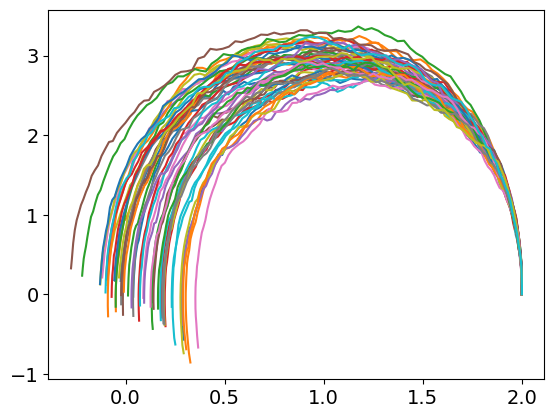

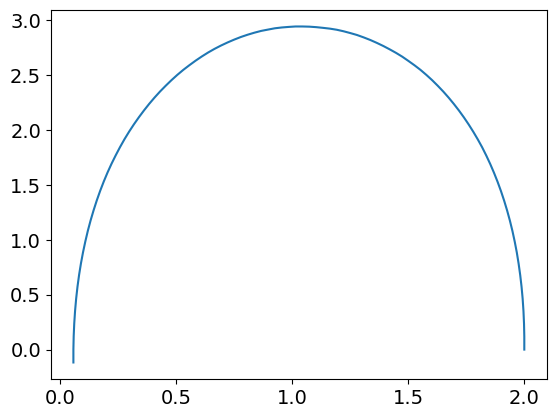

In [12]:
plt.figure()
for i in range(50):
    plt.plot(X_backward[:,i,0], X_backward[:,i,1])
plt.show()

plt.figure()
plt.plot(X_backward[:,:,0].mean(axis=1), X_backward[:,:,1].mean(axis=1))
plt.show()

In [13]:
def jacobian(y: torch.Tensor, x: torch.Tensor, need_higher_grad=True) -> torch.Tensor:
    (Jac,) = torch.autograd.grad(
        outputs=(y.flatten(),),
        inputs=(x,),
        grad_outputs=(torch.eye(torch.numel(y)),),
        create_graph=need_higher_grad,
        allow_unused=True,
        is_grads_batched=True
    )
    if Jac is None:
        Jac = torch.zeros(size=(y.shape + x.shape))
    else:
        Jac.reshape(shape=(y.shape + x.shape))
    return Jac

In [14]:
def batched_jacobian(batched_y:torch.Tensor,batched_x:torch.Tensor,need_higher_grad = True) -> torch.Tensor:
    sumed_y = batched_y.sum(dim = 0) # y_shape
    J = jacobian(sumed_y,batched_x,need_higher_grad) # y_shape x N x x_shape
    
    dims = list(range(J.dim()))
    dims[0],dims[sumed_y.dim()] = dims[sumed_y.dim()],dims[0]
    J = J.permute(dims = dims) # N x y_shape x x_shape
    return J

In [15]:
x = torch.tensor([[1.0],[2.0]], requires_grad=True)
y = torch.stack((x[0]**2 + x[1]**2, x[0]*x[1]))
jac = jacobian(y, x)
jac[:,:,0]

tensor([[2., 4.],
        [2., 1.]], grad_fn=<SelectBackward0>)

In [16]:
x = torch.tensor([[1.0,2.0],[3.0,4.0],[5.0,6.0],[7.0,8.0],[9.0,10.0]], requires_grad=True)
y = torch.stack((x[:,0]**2 + x[:,1]**2, x[:,0]*x[:,1]),dim=1)
Bjac = batched_jacobian(y, x)
Bjac

tensor([[[ 2.,  4.],
         [ 2.,  1.]],

        [[ 6.,  8.],
         [ 4.,  3.]],

        [[10., 12.],
         [ 6.,  5.]],

        [[14., 16.],
         [ 8.,  7.]],

        [[18., 20.],
         [10.,  9.]]], grad_fn=<PermuteBackward0>)

In [17]:
temp_test = torch.einsum('ij,tjk->tik', B@B.T, Bjac)
BatchTrace_test = temp_test.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
BatchTrace_test

tensor([[1.],
        [3.],
        [5.],
        [7.],
        [9.]], grad_fn=<SumBackward1>)

In [ ]:
### learning k(x,t)###
t_N = t.repeat(1,N).reshape(T,N,1)
ITERS = 30000
BATCH_SIZE = 32
LR = 1e-4

k = score_nn(n,16)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=500, gamma=0.99)

losses = []
for i in range(ITERS):
    # print(i)
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_backward[:,idx,:]
    X_train = X_train.view(-1, n)
    t_train = t_N[:,idx,:]  
    t_train = t_train.view(-1, 1)
    X_train.requires_grad = True
    k_value = k.forward(X_train, t_train) 
    # print(k_value.shape)
    gk = k_value @ B.T # shape (T*B, n)
    # gk = gk.unsqueeze(1) # shape (T*B, 1, n)
    batch_norm = torch.einsum('tij,tjk->tik', gk.unsqueeze(1), gk.unsqueeze(2)).squeeze(-1) # shape (T*B,1)
    # loss = score_norm

    batch_jac = batched_jacobian(gk, X_train)
    temp = torch.einsum('ij,tjk->tik', B@B.T, batch_jac)
    batch_trace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
    loss = (0.5*batch_norm + batch_trace).sum()/BATCH_SIZE/T
    

    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%1000==0:
        k_value = k.forward(X_train, t_train) 
        gk = k_value @ B.T
        score_norm = torch.sum(gk**2)/BATCH_SIZE/T
        loss = score_norm
        
        BatchJac = batched_jacobian(gk, X_train)
        temp = torch.einsum('ij,tjk->tik', B@B.T, BatchJac)
        BatchTrace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
        loss = 0.5*loss + BatchTrace.sum()/BATCH_SIZE/T
        losses.append(loss.item())

        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 1000/30000, loss = -0.468861341476
Iteration: 2000/30000, loss = -9.146150588989
Iteration: 3000/30000, loss = -16.436344146729
Iteration: 4000/30000, loss = 8.194419860840
Iteration: 5000/30000, loss = -1.951942443848
Iteration: 6000/30000, loss = 9.349311828613
Iteration: 7000/30000, loss = -13.523345947266
Iteration: 8000/30000, loss = -10.700477600098
Iteration: 9000/30000, loss = 0.249725341797
Iteration: 10000/30000, loss = 0.152801513672
Iteration: 11000/30000, loss = -5.410484313965
Iteration: 12000/30000, loss = 19.885505676270
Iteration: 13000/30000, loss = 5.400115966797
Iteration: 14000/30000, loss = -4.466781616211
Iteration: 15000/30000, loss = -1.448471069336
Iteration: 16000/30000, loss = 12.102478027344
Iteration: 17000/30000, loss = -10.665519714355
Iteration: 18000/30000, loss = -8.538673400879
Iteration: 19000/30000, loss = 1.533660888672
Iteration: 20000/30000, loss = -1.214103698730
Iteration: 21000/30000, loss = -19.167907714844
Iteration: 22000/30000,

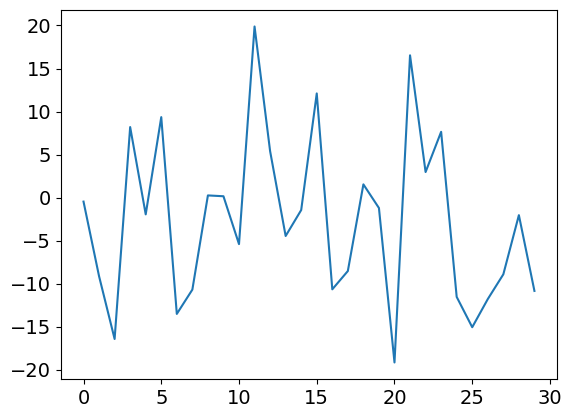

In [19]:
plt.figure()
plt.plot(losses)
plt.show()


In [20]:
exp1tAtrans = generate_expAt(A.T, 1-t)
phi1t = generate_phit(1-t, n)
exp1tA = generate_expAt(A, 1-t)
expt1A = generate_expAt(A, t-1)


In [21]:
y = torch.tensor([[2.0],[2.0]])

In [22]:
W_forward = torch.zeros((T, N, 1))
for i in range(T):
    W_forward[i,:,:] = torch.randn(N,1)*np.sqrt(dt)

In [23]:
k_record = torch.zeros((T, N, 1))
u_s_record = torch.zeros((T, N, 1))
u1_record = torch.zeros((T, N, 1))
u2_record = torch.zeros((T, N, 1))
u3_record = torch.zeros((T, N, 1))
X_pred = torch.zeros((T, N, n))
X_pred[0,:,:] = torch.zeros((N,n))
X_pred2 = torch.zeros((T, N, n))
X_pred2[0,:,:] = torch.zeros((N,n))
X_pred3 = torch.zeros((T, N, n))
X_pred3[0,:,:] = torch.zeros((N,n))

for i in range(1, T):

    ## NN method
    k_value = k.forward(X_pred[i-1,:,:], t[i-1].repeat(N,1))
    k_record[i,:,:] = k_value
    u = U_d[i-1,:].repeat(N,1) + k_value
    u1_record[i-1,:,:] = u
    dX = (A @ X_pred[i-1,:,:].T  + B @ u.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred[i,:,:] = X_pred[i-1,:,:] + dX

    ## u deterministic + u stochastic method
    u_s_record[i,:,:] = -(X_pred2[i-1,:,:] - X_forward[i-1,:])@ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    u2 = U_d[i-1,:].repeat(N,1) + u_s_record[i,:,:]
    u2_record[i-1,:,:] = u2
    dX2 = (A @ X_pred2[i-1,:,:].T  + B @ u2.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred2[i,:,:] = X_pred2[i-1,:,:] + dX2
    
    ## u feedback method
    u3 = -(X_pred3[i-1,:,:] - (expt1A[i-1,:,:] @ y).repeat(1,N).T) @ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    u3_record[i-1,:,:] = u3
    dX3 = (A @ X_pred3[i-1,:,:].T  + B @ u3.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred3[i,:,:] = X_pred3[i-1,:,:] + dX3
    

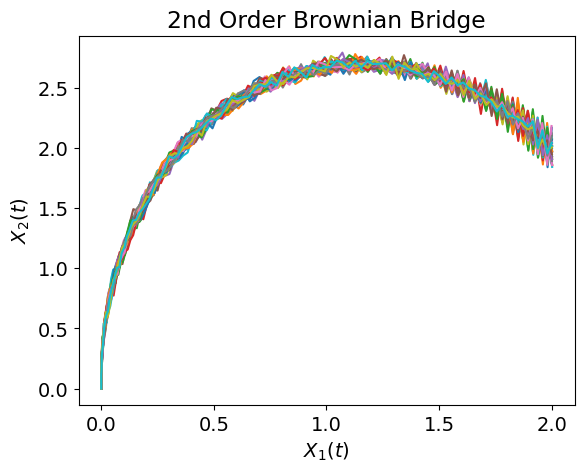

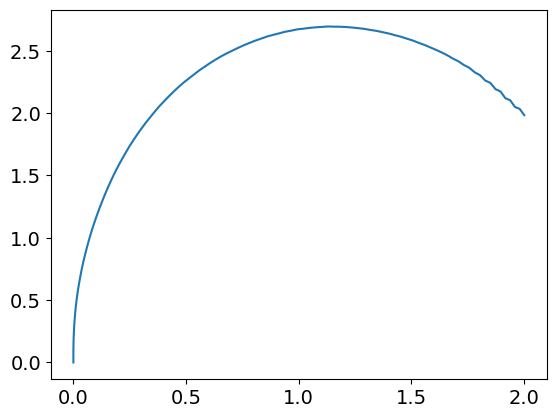

In [24]:
plt.figure()
for i in range(50):
    plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy())
plt.title('2nd Order Brownian Bridge')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.show()

plt.figure()
plt.plot(X_pred[:,:,0].mean(axis=1).detach().numpy(), X_pred[:,:,1].mean(axis=1).detach().numpy())
plt.show()

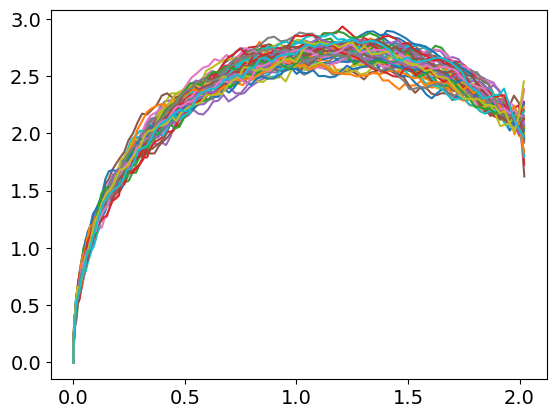

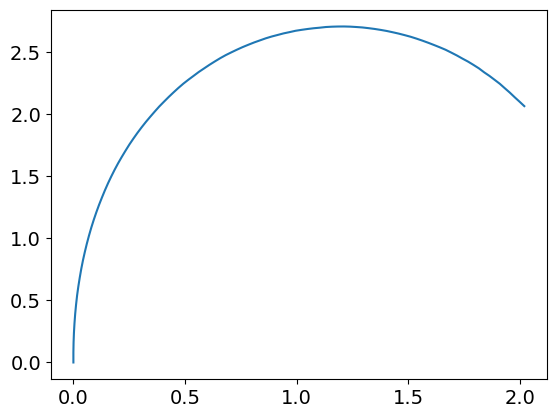

In [25]:
plt.figure()
for i in range(50):
    plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy())
plt.show()

plt.figure()
plt.plot(X_pred2[:,:,0].mean(axis=1).detach().numpy(), X_pred2[:,:,1].mean(axis=1).detach().numpy())
plt.show()

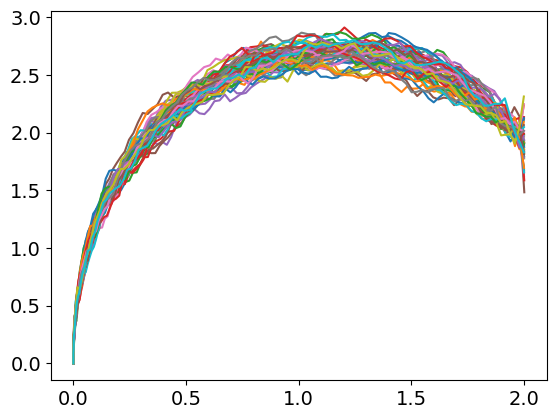

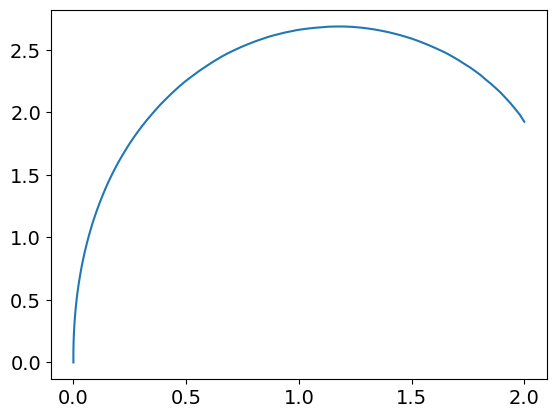

In [26]:
plt.figure()
for i in range(50):
    plt.plot(X_pred3[:,i,0].detach().numpy(), X_pred3[:,i,1].detach().numpy())
plt.show()

plt.figure()
plt.plot(X_pred3[:,:,0].mean(axis=1).detach().numpy(), X_pred3[:,:,1].mean(axis=1).detach().numpy())
plt.show()

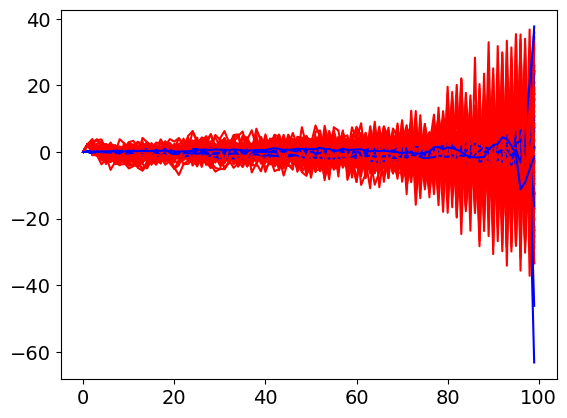

In [27]:
plt.figure()
for i in range(50):
    plt.plot(k_record[:,i,0].detach().numpy(), color='r')
    plt.plot(u_s_record[:,i,0].detach().numpy(), color='b')
plt.show()

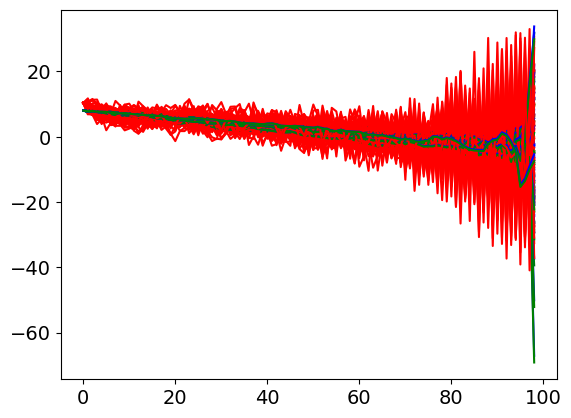

In [28]:
plt.figure()
for i in range(50):
    plt.plot(u1_record[:99,i,0].detach().numpy(), color='r')
    plt.plot(u2_record[:99,i,0].detach().numpy(), color='b')
    plt.plot(u3_record[:99,i,0].detach().numpy(), color='g')
plt.show()